<a href="https://colab.research.google.com/github/sagar9926/MTech_Atificial_Intelligence/blob/main/ML1/Fractal3_Assignment/Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3
7. Exercises

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn


import torch.nn.functional as F
import torch.optim as optim
import math
import albumentations as A
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [3]:
transform_train = transforms.Compose([
    transforms.RandomRotation((-14.0, 14.0)),
    #A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=0.5),
    #transforms.RandomResizedCrop(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    transforms.RandomErasing(),
    ])

transform_test = transforms.Compose([
    #transforms.RandomResizedCrop(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    ])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
num_classes = 10

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [29]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
9


In [55]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5 # denormalising the image
    plt.figure(figsize=(batch_size*20, 2))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [56]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images) # puts together images to form a bigger image
    imshow(img, title=[trainset.classes[x.item()] for x in labels])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


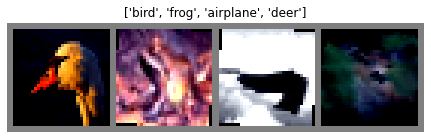

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


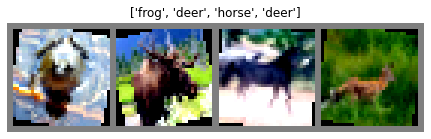

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


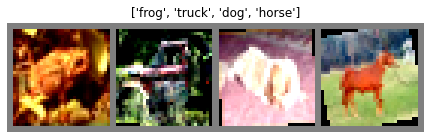

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


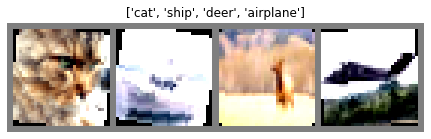

In [57]:
for i in range(4):
    show_batch_images(trainloader)

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(48),   
            nn.ReLU()
         
        ) # output_size = [N , 48 , 32 , 32]

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(48),   
            nn.ReLU()
         
        ) # output_size = [N , 48 , 30 , 30]

        # pooling layer
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = [N , 48 , 15 , 15]

        self.convblock3 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(96), 
            nn.ReLU()
        ) # output_size = [N , 96 , 15 , 15]

        self.convblock4 = nn.Sequential(
            #nn.Dropout(0.25),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(96), 
            nn.ReLU()
        ) # output_size = [N , 96 , 13 , 13]

        # pooling layer
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = [N , 96 , 6 , 6]

        self.convblock5 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU()
        ) # output_size = [N , 192 , 6 , 6]

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.Dropout(0.25)
        ) # output_size = [N , 192 , 4 , 4]

        self.fc_model = nn.Sequential(
            nn.Linear(3072*2,512),         # (N, 400) -> (N, 120)
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512,256),          # (N, 120) -> (N, 84)
            nn.Linear(256,10)            # (N, 84)  -> (N, 10)
        )
      

    def forward(self, x):
        img = copy.deepcopy(x)
               
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)

        
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)

        x = self.convblock5(x)
        x = self.convblock6(x)
        x = x.view(x.size(0), -1) # (N, 16, 5, 5) -> (N, 400)
        
        x = torch.cat((x,img.reshape(x.size(0),-1)),dim = 1)
        
        x = self.fc_model(x)

        return F.log_softmax(x, dim=-1)


In [11]:
from torchsummary import summary
net = Net().to(device)
print(summary(net, (3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,296
       BatchNorm2d-2           [-1, 48, 32, 32]              96
              ReLU-3           [-1, 48, 32, 32]               0
            Conv2d-4           [-1, 48, 30, 30]          20,736
       BatchNorm2d-5           [-1, 48, 30, 30]              96
              ReLU-6           [-1, 48, 30, 30]               0
         MaxPool2d-7           [-1, 48, 15, 15]               0
           Dropout-8           [-1, 48, 15, 15]               0
            Conv2d-9           [-1, 96, 15, 15]          41,472
      BatchNorm2d-10           [-1, 96, 15, 15]             192
             ReLU-11           [-1, 96, 15, 15]               0
           Conv2d-12           [-1, 96, 13, 13]          82,944
      BatchNorm2d-13           [-1, 96, 13, 13]             192
             ReLU-14           [-1, 96,

### Train CIFAR10

In [12]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [13]:
def evaluation(dataloader,model):
  total , correct = 0,0
  for data in dataloader:
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total


In [14]:
# vgg = vgg.to(device)
net = Net().to(device)

loss_fn = nn.CrossEntropyLoss() #this takes into consideration that we have to differentiate through softmax layer, given softmax is not applied in our vgg
opt = optim.SGD(net.parameters(), lr=0.01,momentum = 0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=len(trainloader)*10, gamma=0.01)


In [15]:
loss_epoch_arr = []
max_epochs = 150
train_acc = []
val_acc = []

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        #scheduler.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
    train_acc.append(evaluation(trainloader, net))
    val_acc.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))
    
#plt.plot(loss_epoch_arr)
#plt.show()

Iteration: 0/782, Loss: 2.31
Iteration: 500/782, Loss: 1.33
Epoch: 1/150, Test acc: 55.67, Train acc: 52.39
Iteration: 0/782, Loss: 1.39
Iteration: 500/782, Loss: 1.09
Epoch: 2/150, Test acc: 63.41, Train acc: 60.21
Iteration: 0/782, Loss: 0.93
Iteration: 500/782, Loss: 1.07
Epoch: 3/150, Test acc: 67.63, Train acc: 64.51
Iteration: 0/782, Loss: 1.01
Iteration: 500/782, Loss: 0.98
Epoch: 4/150, Test acc: 70.73, Train acc: 66.99
Iteration: 0/782, Loss: 0.69
Iteration: 500/782, Loss: 1.01
Epoch: 5/150, Test acc: 71.02, Train acc: 68.14
Iteration: 0/782, Loss: 0.79
Iteration: 500/782, Loss: 0.78
Epoch: 6/150, Test acc: 72.68, Train acc: 69.71
Iteration: 0/782, Loss: 0.99
Iteration: 500/782, Loss: 0.78
Epoch: 7/150, Test acc: 74.06, Train acc: 71.09
Iteration: 0/782, Loss: 1.02
Iteration: 500/782, Loss: 0.69
Epoch: 8/150, Test acc: 75.12, Train acc: 72.86
Iteration: 0/782, Loss: 0.73
Iteration: 500/782, Loss: 0.66
Epoch: 9/150, Test acc: 76.75, Train acc: 74.30
Iteration: 0/782, Loss: 0.69

In [16]:
transform_train = transforms.Compose([
    transforms.RandomRotation((-14.0, 14.0)),
    #A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=0.5),
    #transforms.RandomResizedCrop(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    #transforms.RandomErasing(),
    ])

transform_test = transforms.Compose([
    #transforms.RandomResizedCrop(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.4913997551666284, 0.48215855929893703, 0.4465309133731618), (0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)


trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle = True)


Files already downloaded and verified
Files already downloaded and verified


In [17]:
max_epochs = 10

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        #scheduler.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 500 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
    train_acc.append(evaluation(trainloader, net))
    val_acc.append(evaluation(testloader, net))

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch + 1, max_epochs, 
        evaluation(testloader, net), evaluation(trainloader, net)))
    
#plt.plot(loss_epoch_arr)
#plt.show()

Iteration: 0/782, Loss: 0.08
Iteration: 500/782, Loss: 0.02
Epoch: 1/10, Test acc: 84.69, Train acc: 97.58
Iteration: 0/782, Loss: 0.17
Iteration: 500/782, Loss: 0.10
Epoch: 2/10, Test acc: 84.88, Train acc: 97.48
Iteration: 0/782, Loss: 0.08
Iteration: 500/782, Loss: 0.10
Epoch: 3/10, Test acc: 84.81, Train acc: 97.40
Iteration: 0/782, Loss: 0.07
Iteration: 500/782, Loss: 0.09
Epoch: 4/10, Test acc: 84.39, Train acc: 97.49
Iteration: 0/782, Loss: 0.04
Iteration: 500/782, Loss: 0.13
Epoch: 5/10, Test acc: 85.02, Train acc: 97.80
Iteration: 0/782, Loss: 0.04
Iteration: 500/782, Loss: 0.05
Epoch: 6/10, Test acc: 84.74, Train acc: 97.62
Iteration: 0/782, Loss: 0.02
Iteration: 500/782, Loss: 0.00
Epoch: 7/10, Test acc: 85.05, Train acc: 97.77
Iteration: 0/782, Loss: 0.02
Iteration: 500/782, Loss: 0.06
Epoch: 8/10, Test acc: 84.99, Train acc: 97.80
Iteration: 0/782, Loss: 0.02
Iteration: 500/782, Loss: 0.05
Epoch: 9/10, Test acc: 85.12, Train acc: 97.69
Iteration: 0/782, Loss: 0.06
Iteratio

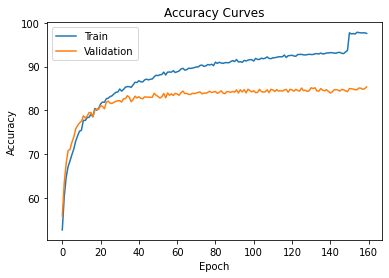

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_acc,label='Train')
ax.plot(val_acc, label='Validation')

plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

plt.savefig("Accuracy curves")

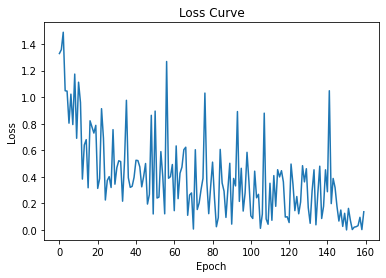

In [21]:
plt.plot(loss_epoch_arr)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()